# Building Decision Trees

**Decision Trees** are like playing "20 Questions" with data. At each step, you ask a yes/no question that splits your data into two groups, trying to create groups that are as "pure" (all one class) as possible.

Think of it like identifying poisonous mushrooms:
- **Question 1**: "Does it smell foul?" → If yes, it's **probably poisonous**
- **Question 2**: "Does it have close gill spacing?" → This helps further classify
- Continue until you're confident about edible vs. poisonous

**Why Decision Trees?**
- Easy to understand and visualize
- Show you *which features matter* and *why*
- Make predictions by following a simple path
- Don't require data scaling or normalization

**The Big Idea:** Use the features with highest **Information Gain** (from the previous notebook!) to split the data, creating a tree of decisions that leads to predictions.

---

In this notebook, you'll:
1. Build your first decision tree
2. Visualize how it makes decisions
3. Understand which features it chose and why
4. Experiment with tree complexity
5. See how trees avoid overfitting

## Setup: Load the Mushroom Dataset

We'll use the same mushroom dataset from previous notebooks. Our goal: build a tree that can identify poisonous mushrooms!

In [1]:
import cuanalytics as ca
# Load data
df = cuanalytics.load_mushroom_data()

# Split into training and test sets
# Training: for building the tree
# Test: for evaluating how well it works on NEW data
train_df, test_df = cuanalytics.split_data(df, test_size=0.3, random_state=42)

print(f"Total mushrooms: {len(df)}")
print(f"Training set: {len(train_df)} mushrooms")
print(f"Test set: {len(test_df)} mushrooms")
print(f"\nClass distribution in training set:")
print(train_df['class'].value_counts())

Total mushrooms: 8124
Training set: 5686 mushrooms
Test set: 2438 mushrooms

Class distribution in training set:
class
e    2951
p    2735
Name: count, dtype: int64


## Step 1: Build Your First Decision Tree

Let's start with a **shallow tree** (max depth = 2). This means:
- The tree can only ask **2 questions** before making a prediction
- It will choose the 2 *most informative* features

**Prediction:** Based on the Information Gain notebook, which feature do you think will be chosen first?

In [2]:
# Build a shallow tree (max depth = 2)
# This limits the tree to 2 levels of questions
tree = cuanalytics.fit_tree(train_df, formula='class ~ .', max_depth=2)

print("\n💡 Notice: The tree uses 'entropy' as its criterion.")
print("This means it picks features that maximize Information Gain!")

tree.summary()


Decision Tree fitted successfully!
  Classes: ['e', 'p']
  Features: 22 original (117 after encoding)
  Numeric features: []
  Categorical features: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
  Training samples: 5686
  Max depth: 2
  Criterion: entropy

💡 Notice: The tree uses 'entropy' as its criterion.
This means it picks features that maximize Information Gain!

DECISION TREE MODEL SUMMARY

MODEL INFORMATION:
----------------------------------------------------------------------
Target: class
Number of features: 22 original (117 after encoding)
Classes: ['e', 'p']
Training samples: 5686
Max depth: 2
Criterion: entropy

TRAINING FIT:
-------------------------------------

## Step 2: Visualize the Tree

Let's see the actual decision tree! Each box (node) shows:
- **The question being asked** (e.g., "odor_n <= 0.5")
- **Number of samples** at that node
- **Class distribution** [edible, poisonous]
- **Predicted class** (determined by majority)
- **Node color**: darker = more pure (certain)

**How to read it:**
- Start at the top (root)
- Follow the path based on "True" (left) or "False" (right)
- End at a leaf node for the prediction

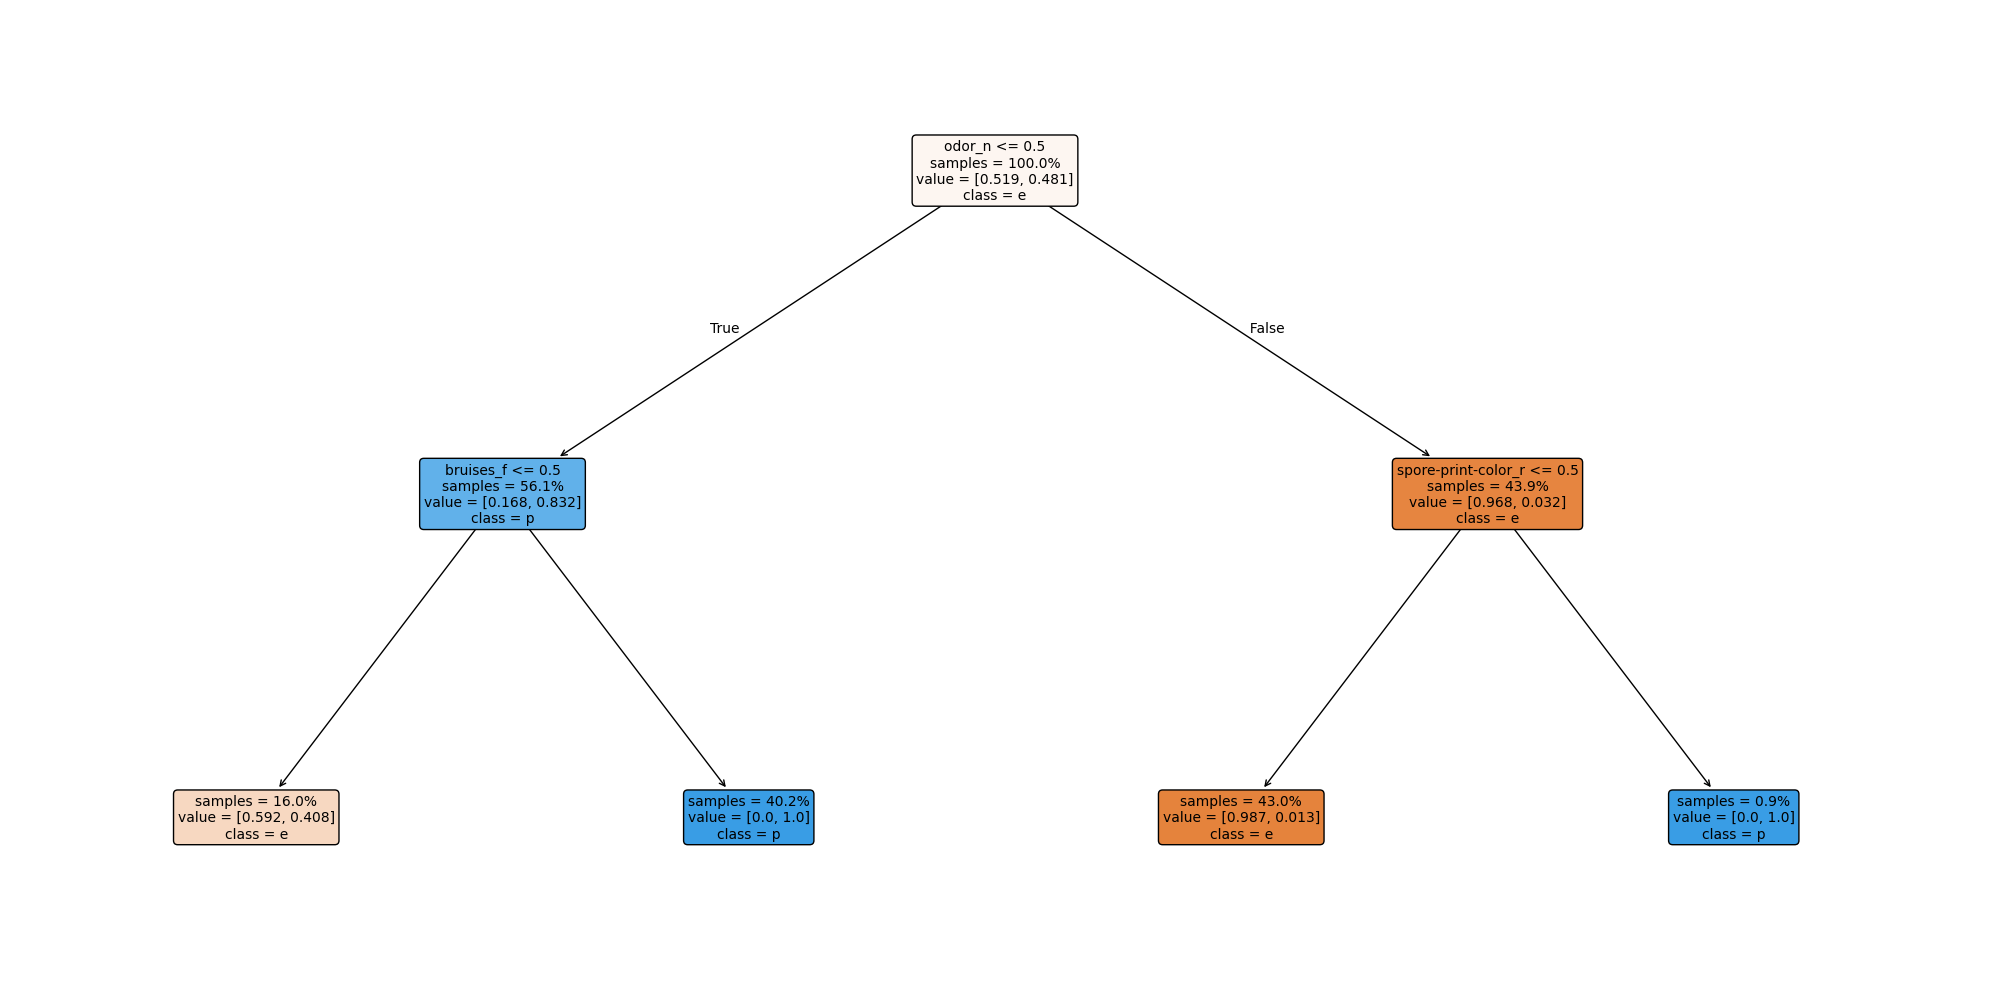


Decision Tree Visualization:
  • Node color = dominant class
  • Darker color = more confident (purer node)
  • Each node shows: split condition, samples, and class distribution

💡 Study the tree above! Notice:
- The FIRST split is on 'odor' - our champion feature!
- Each split tries to separate edible from poisonous
- The darker the node color, the more 'pure' it is


In [3]:
tree.visualize(show_probabilities=True)

print("\n💡 Study the tree above! Notice:")
print("- The FIRST split is on 'odor' - our champion feature!")
print("- Each split tries to separate edible from poisonous")
print("- The darker the node color, the more 'pure' it is")

## Step 3: Evaluate Performance

**Key Question:** How well does our simple 2-question tree classify mushrooms?

Remember: We test on the **test set** (data the tree has never seen) to see if it generalizes!

In [6]:
accuracy = tree.score(test_df)
print(f"Accuracy: {accuracy['accuracy']:.2%}")
print(f"\n💡 Interpretation:")
print(f"Our tree correctly classifies {accuracy['accuracy']*100:.1f}% of mushrooms")
print(f"using just 2 simple questions!")
print(f"\nThat's impressive for such a shallow tree!")
print(f"This shows that 'odor' and the second feature are very informative.")


SCORE REPORT
Accuracy: 92.21%
Kappa: 0.8432

Confusion Matrix:
          Pred e  Pred p
Actual e    1257       0
Actual p     190     991

Per-Class Metrics:
   precision  recall  sensitivity  specificity     f1
e     0.8687  1.0000       1.0000       0.8391 0.9297
p     1.0000  0.8391       0.8391       1.0000 0.9125
Accuracy: 92.21%

💡 Interpretation:
Our tree correctly classifies 92.2% of mushrooms
using just 2 simple questions!

That's impressive for such a shallow tree!
This shows that 'odor' and the second feature are very informative.


## Step 4: View the Decision Rules

Trees make decisions using simple if-then rules. Each rule traces a complete path from the root to a leaf node, showing ALL conditions that must be satisfied for that prediction.

**Example format:** IF (Balance < 50K) AND (Age >= 50) THEN Class=Approved

Let's see the rules for our mushroom tree!

In [7]:
rules = tree.get_rules()
print(rules)

print("\n💡 How to read these rules:")
print("- Each rule traces a complete path from root to leaf")
print("- All conditions joined by AND must be true")
print("- Conditions use <= (less than or equal) or > (greater than)")
print("- Class=e means 'edible', Class=p means 'poisonous'")
print("\nThese rules show the exact logic the tree uses to classify mushrooms!")

Decision Tree Rules:
Rule 1: IF (odor_n <= 0.50) AND (bruises_f <= 0.50) THEN Class=e
Rule 2: IF (odor_n <= 0.50) AND (bruises_f > 0.50) THEN Class=p
Rule 3: IF (odor_n > 0.50) AND (spore-print-color_r <= 0.50) THEN Class=e
Rule 4: IF (odor_n > 0.50) AND (spore-print-color_r > 0.50) THEN Class=p

💡 How to read these rules:
- Each rule traces a complete path from root to leaf
- All conditions joined by AND must be true
- Conditions use <= (less than or equal) or > (greater than)
- Class=e means 'edible', Class=p means 'poisonous'

These rules show the exact logic the tree uses to classify mushrooms!


## Step 5: Feature Importance - Which Features Matter?

**Feature Importance** tells us which features the tree relied on most heavily.

**Calculation:** Based on how much each feature reduced entropy when used for splitting.

**Remember:** This connects back to Information Gain!

In [8]:
importance = tree.get_feature_importance()

print("Top 10 Most Important Features:")
print("=" * 60)
top_10 = importance.head(10)
print(top_10.to_string(index=False))

print("\n💡 Notice:")
print("- Only features actually USED in the tree have importance > 0")
print("- Since our tree has max_depth=2, only a few features are used")
print("- The top feature should be 'odor' - our champion from before!")

Top 10 Most Important Features:
                 feature  importance
                  odor_n    0.676676
               bruises_f    0.264101
     spore-print-color_r    0.059222
             cap-shape_b    0.000000
stalk-color-below-ring_g    0.000000
            veil-color_y    0.000000
            veil-color_w    0.000000
            veil-color_o    0.000000
            veil-color_n    0.000000
             veil-type_p    0.000000

💡 Notice:
- Only features actually USED in the tree have importance > 0
- Since our tree has max_depth=2, only a few features are used
- The top feature should be 'odor' - our champion from before!


## Step 6: Visualize Decision Boundaries

Let's see how the tree separates the two most important features visually.

**What you'll see:**
- How the tree "carves up" the feature space
- Which regions are classified as edible vs. poisonous
- The decision boundaries created by the tree's rules

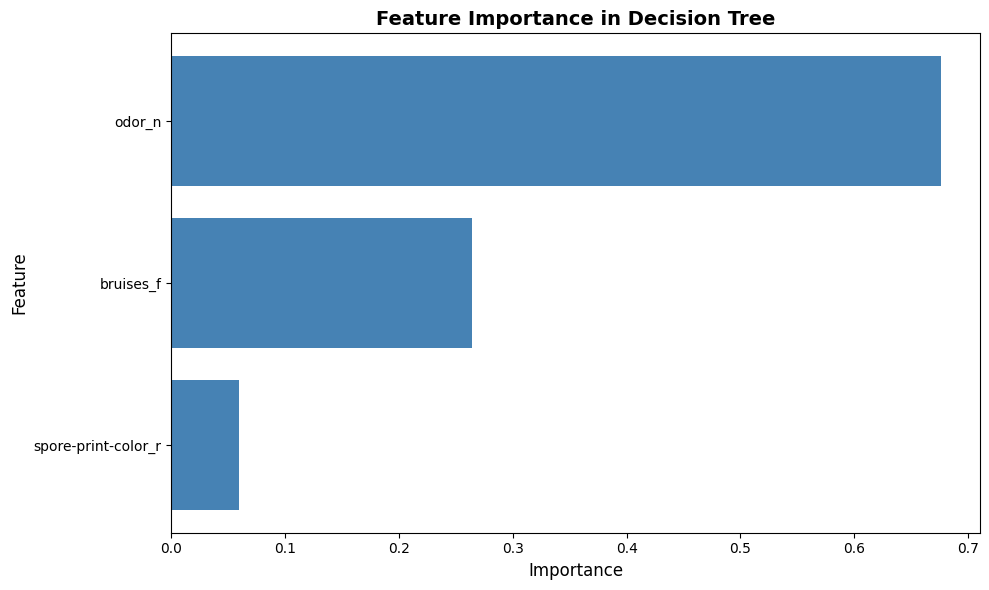


💡 Only 3 features were used in this shallow tree!


In [9]:
# Visualize feature importance
import matplotlib.pyplot as plt

top_features = importance[importance['importance'] > 0].head(10)

if len(top_features) > 0:
    plt.figure(figsize=(10, 6))
    plt.barh(top_features['feature'], top_features['importance'], color='steelblue')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title('Feature Importance in Decision Tree', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    print(f"\n💡 Only {len(top_features)} features were used in this shallow tree!")
else:
    print("No features with importance > 0 found.")

## 🎓 Final Challenge

**Build the best decision tree you can!**

Your goal: Maximize test accuracy while keeping the model interpretable.

**Constraints:**
- Max depth ≤ 10 (keep it interpretable)
- Use only the training set to build the tree
- Evaluate on the test set

**Extensions to try:**
1. Try different splitting criteria (if available in the library)
2. Visualize the final tree and explain its top 3 splits
3. Identify the most important features
4. Can you beat 99% accuracy?

Good luck! 🚀

In [ ]:
# Your final challenge code here!
# Build your best tree and see how well it performs!

# Example:
# best_tree = cuanalytics.fit_tree(train_df, formula='class ~ .', max_depth=???)
# final_report = best_tree.score(test_df)
# final_accuracy = final_report['accuracy']
# print(f"Final Test Accuracy: {final_accuracy:.2%}")
# best_tree.visualize(show_probabilities=True)

## Key Takeaways

**1. Decision Trees = Automated "20 Questions"**
   - At each node, ask the question that reduces uncertainty the most
   - Use information gain to pick the best feature at each step
   - Continue until leaves are pure or depth limit is reached

**2. Trees are Greedy Learners**
   - They pick the BEST feature at each step (locally optimal)
   - Don't look ahead to future splits
   - This makes them fast but sometimes suboptimal

**3. Interpretability is a Superpower**
   - You can see exactly which features matter
   - You can trace the logic for any prediction
   - Non-technical stakeholders can understand the rules

**4. Depth Controls Complexity**
   - Shallow trees = simple, might underfit
   - Deep trees = complex, might overfit
   - Find the sweet spot using validation/test data

**5. Information Gain is the Engine**
   - Trees use entropy and information gain (from earlier notebooks!)
   - Each split maximizes information gain
   - Feature importance = cumulative information gain from that feature

**6. Connection to Earlier Notebooks**
   - Entropy (Notebook 01): Measures uncertainty at each node
   - Information Gain (Notebook 02): Decides which feature to split on
   - Visualization (Notebook 03): Shows purity of subsets created by splits
   - Decision Trees: Puts it all together into a prediction model!

## Real-World Considerations

**When to use Decision Trees:**
- ✅ You need an interpretable model (can explain decisions to stakeholders)
- ✅ You have categorical features (trees handle them naturally)
- ✅ You want to identify which features matter most
- ✅ You don't want to spend time on feature scaling/normalization

**When to be careful:**
- ⚠️ Very deep trees can overfit (use cross-validation to find optimal depth)
- ⚠️ Trees can be unstable (small data changes → different tree)
- ⚠️ They create axis-parallel splits (can't capture diagonal boundaries well)
- ⚠️ Biased toward features with many categories

**Solutions to these issues:**
- Use **ensemble methods** (Random Forests, Gradient Boosting)
- Set **max_depth** or **min_samples_split** to control complexity
- Use **cross-validation** to find optimal hyperparameters

In [ ]:
# Calculate information gain for a few features (like we did in notebook 02)
ig_odor = cuanalytics.information_gain(train_df, 'odor', 'class')
ig_gill = cuanalytics.information_gain(train_df, 'gill-spacing', 'class')
ig_bruises = cuanalytics.information_gain(train_df, 'bruises', 'class')
ig_shape = cuanalytics.information_gain(train_df, 'cap-shape', 'class')

print("Information Gain of Various Features:")
print("=" * 60)
print(f"odor:           {ig_odor:.4f} ← HIGHEST!")
print(f"gill-spacing:   {ig_gill:.4f}")
print(f"bruises:        {ig_bruises:.4f}")
print(f"cap-shape:      {ig_shape:.4f}")

print("\n💡 The decision tree picks 'odor' first because it has")
print("the highest information gain!")
print("\nLook back at Step 2 - the root node splits on odor!")

## How Decision Trees Connect to Information Gain

Let's trace back to what we learned in earlier notebooks:

**Remember from the Information Gain notebook:**
- Odor had the highest information gain (90.7% uncertainty reduction)
- Gill-spacing had moderate information gain (39.8%)
- Cap-shape had very low information gain (0.7%)

**Decision trees use this!**
- At each node, they calculate information gain for ALL remaining features
- They pick the feature with the HIGHEST information gain
- This greedy approach builds the tree level by level

Let's verify this by looking at our tree's first split:

**What to notice in the plot:**

1. **Training accuracy increases** as depth increases (the tree can memorize more)
2. **Test accuracy plateaus** or might even decrease at very high depths (overfitting!)
3. The **gap between training and test** indicates how much the tree is overfitting

**Key Insight:** The best tree isn't necessarily the deepest or the most complex - it's the one that generalizes best to new data!

In [ ]:
import matplotlib.pyplot as plt

# Test different depths
depths = [1, 2, 3, 4, 5, 6, 8, 10, 15, 20]
train_accuracies = []
test_accuracies = []

for depth in depths:
    temp_tree = cuanalytics.fit_tree(train_df, formula='class ~ .', max_depth=depth)
    train_acc = temp_tree.score(train_df)['accuracy']
    test_acc = temp_tree.score(test_df)['accuracy']
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accuracies, 'o-', label='Training Accuracy', linewidth=2, markersize=8)
plt.plot(depths, test_accuracies, 's-', label='Test Accuracy', linewidth=2, markersize=8)
plt.xlabel('Tree Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Decision Tree Accuracy vs. Depth', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find optimal depth
optimal_idx = test_accuracies.index(max(test_accuracies))
optimal_depth = depths[optimal_idx]
print(f"\n🏆 Optimal depth: {optimal_depth}")
print(f"Test accuracy: {test_accuracies[optimal_idx]:.2%}")

## Bonus: Visualize Multiple Depths Side-by-Side

Let's systematically compare trees of different depths to see the accuracy vs. complexity tradeoff.

In [ ]:
# Your code here!
# Example:
# tree_depth_3 = cuanalytics.fit_tree(train_df, formula='class ~ .', max_depth=3)
# acc_3 = tree_depth_3.score(test_df)['accuracy']
# print(f"Depth 3: {acc_3:.2%}")

# Try different depths and compare!

## 🎯 Your Turn: Find the Optimal Depth

**Challenge:** Build trees with different depths and find the best one!

Try depths of 3, 4, 6, 8, and 10. Which gives the best test accuracy?

**Watch out for:**
- **Underfitting:** Tree too shallow, misses important patterns
- **Overfitting:** Tree too deep, memorizes training data but doesn't generalize

*Hint: The optimal depth might surprise you!*

In [ ]:
# Compare feature importance
deep_importance = deeper_tree.get_feature_importance()
deep_features_used = deep_importance[deep_importance['importance'] > 0]

print(f"Shallow tree uses {len(importance[importance['importance'] > 0])} features")
print(f"Deeper tree uses {len(deep_features_used)} features")

print("\nTop features in deeper tree:")
print("=" * 60)
print(deep_features_used.head(8).to_string(index=False))

In [ ]:
# Build a deeper tree (max depth = 5)
deeper_tree = cuanalytics.fit_tree(train_df, formula='class ~ .', max_depth=5)

# Compare accuracies
shallow_acc = tree.score(test_df)['accuracy']
deep_acc = deeper_tree.score(test_df)['accuracy']

print(f"Shallow Tree (depth=2): {shallow_acc:.2%}")
print(f"Deeper Tree (depth=5):  {deep_acc:.2%}")
print(f"\nImprovement: {(deep_acc - shallow_acc)*100:.1f} percentage points")

print("\n💡 Notice:")
print("The deeper tree performs better - it can make more nuanced decisions!")
print("Let's see how many features it uses...")

## Step 7: Experiment with Tree Depth

**Key Question:** What happens if we make the tree deeper?

- **Deeper trees** = more questions = can capture more complex patterns
- **BUT** = risk of **overfitting** (memorizing training data instead of learning patterns)

Let's build a deeper tree and compare!

In [ ]:
tree.visualize_features(feature1='odor', feature2='bruises')